<div style="border: 3px solid #e91e63; border-radius: 10px; padding: 18px; background: linear-gradient(to right, #ffe3f0, #e1f5fe); font-family: 'Segoe UI', sans-serif; color: #2e2e2e;">

<h2 style="color:#c2185b; display: flex; align-items: center;">
  <img src="https://img.icons8.com/fluency/40/bank.png" style="margin-right:12px;">
  <strong>Unlocking Insights from the Vault: A Bank EDA Journey</strong>
</h2>

<p style="font-size: 16px;">
  This notebook demonstrates <strong>SQL-powered Exploratory Data Analysis (EDA)</strong> of Banking Data using <strong>SQLAlchemy</strong> with Python and visualizations.
</p>

<ul style="list-style: none; font-size: 15px; padding-left: 0;">
  <li>📂 <strong>Data Tables</strong>: <span style="color:#0288d1;">Customers</span>, <span style="color:#0288d1;">Accounts</span>, <span style="color:#0288d1;">Transactions</span>, <span style="color:#0288d1;">Branches</span></li>
  <li>✨ <strong>Features</strong>: Top loan holders, missing data checks, credit activity, inactivity tracking, branch-wise summaries, and transaction trends</li>
</ul>

<p style="margin-top: 12px; font-size: 14px;"><em>Let’s open the vault of insights and unlock powerful banking intelligence 💡🔍</em></p>

</div>


# 🧾 Table of Contents

---

### 📂 1. Introduction
- Overview of the Project
- Objective & Scope

### 🏗️ 2. Database Design & Schema
- Schema Diagram
- Customers Table (DDL + Preview)
- Accounts Table
- Transactions Table
- Branches Table

### 🔍 3. Data Cleaning & Preparation
- Missing Value Treatment
- Phone & Email Cleanup
- Type Conversion (Date, Balance, etc.)
- Final Aligned Tables

### 📊 4. Exploratory Data Analysis (EDA)
- Univariate Analysis (Age, Balance, etc.)
- Bivariate Analysis (Loan vs. Balance, etc.)
- Branch-wise Statistics
- Inactive Customers (90-day cutoff)
- Credit Card & Loan Distribution

### 🧠 5. Feature Engineering
- Loan-to-Balance Ratio
- Credit Scoring (Rule-based)
- Inactivity Flags

### 📈 6. Visual Insights
- Branch-wise Balance Distribution
- Age vs. Loan Correlation
- Transaction Frequency Trends

### ✅ 7. Key Takeaways & Business Insights
- Top Risk Profiles
- Branch Performance
- Revenue Opportunities

### 💾 8. Appendix
- Data Sources
- SQLAlchemy Setup
- Utility Functions

## 🧱 1. Database Design & Schema

In [ ]:
-- Sample MySQL DDL

CREATE TABLE aligned_customers_ws (
    customer_id VARCHAR(20) PRIMARY KEY,
    name VARCHAR(100),
    age INT,
    gender VARCHAR(10),
    email VARCHAR(100),
    phone VARCHAR(20),
    branch_id VARCHAR(10)
);

1. Customers Table (customers.csv)
•	Rows: 1102
•	Key Columns:
o	customer_id (PK)
o	name, age, gender, email, phone, address
o	branch_id (FK to branches)


CREATE TABLE aligned_account_ws (
    account_id VARCHAR(20) PRIMARY KEY,
    customer_id VARCHAR(20),
    account_type VARCHAR(20),
    balance DECIMAL(12,2),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);

2. Accounts Table (accounts.csv)
•	Rows: 504
•	Key Columns:
o	account_id (PK)
o	customer_id (FK)
o	account_type (savings, current, FD, RD)
o	balance, loan_amount
o	credit_card, scheme
o   branch_id


CREATE TABLE aligned_transaction_ws (
    transaction_id VARCHAR(30) PRIMARY KEY,
    account_id VARCHAR(20),
    customer_id VARCHAR(20),
    amount DECIMAL(10,2),
    transaction_type VARCHAR(10),
    formatted_date DATE,
    FOREIGN KEY (account_id) REFERENCES accounts(account_id)
);

3. Transactions Table (transactions.csv)
•	Rows: 3000
•	Key Columns:
o	transaction_id (PK)
o	customer_id (FK)
o	amount, transaction_type (debit/credit)
o	date, description


CREATE TABLE branches (
    branch_id VARCHAR(10) PRIMARY KEY,
    branch_name VARCHAR(50),
    city VARCHAR(50)
);

4. branches Table (branches.csv)
•	Rows: 10
•	Key Columns:
o	branch_id (PK)
o	branch_name, manager, branch_address, contact_number

## 🐍 2. Python Setup and EDA Pipeline

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the password and, importantly, the database name
db_user = 'root'
db_password = 'nikitasql'
db_host = 'localhost'
db_name = 'github_db' 

engine = create_engine(f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}')

## 🔁 Typical EDA Pipeline Steps:

**1.🗃️Data Collection:**

- Fetching data from SQL databases, CSV files, APIs, etc.

- Example: pd.read_sql() or pd.read_csv()

In [4]:
# Load Tables 

# customers = pd.read_sql("SELECT * FROM customers_raw", engine)
accounts = pd.read_sql("SELECT * FROM aligned_account_ws", engine)
# transactions = pd.read_sql("SELECT * FROM aligned_transaction_ws", engine)
# branches = pd.read_sql("SELECT * FROM branches", engine)
accounts

,account_id,customer_id,account_type,balance,credit_card,scheme,loan_amount,branch_id,loan_balance_ratio,loan_risk_label
0,CUR000000001,CUST000001,Current,369877.5267,No,Platinum,73933,1,0.2,🟢 Safe_risk
1,CUR000000002,CUST000002,Current,355386.7949,Yes,Gold,0,3,None,None
2,CUR000000003,CUST000007,Current,59672.7198,Yes,Senior,0,6,None,None
3,CUR000000004,CUST000008,Current,62634.7300,Yes,Senior,0,9,None,None
4,CUR000000005,CUST000025,Current,442028.3998,Yes,None,0,5,None,None
...,...,...,...,...,...,...,...,...,...,...
499,SAV000000127,CUST000243,Saving,389864.9241,No,Standard,0,9,None,None
500,SAV000000128,CUST000253,Saving,176023.5064,No,Standard,751031,2,4.27,🔴 High risk
501,SAV000000129,CUST000257,Saving,424069.4280,No,Platinum,0,1,None,None
502,SAV000000130,CUST000269,Saving,48006.5100,Yes,Gold,0,8,None,None


In [5]:
# Table in its crude form: Customers

customers = pd.read_sql("SELECT * FROM customer_raw", engine)
customers

,customer_id,name,age,gender,email,phone,address,branch_id,cleaned_phone
0,1,Allison Hill,69,Other,christopher86@gmail.com,+1-111-109-6179x817,"722 Erica Trace, Kingfort, DE 70686",1,None
1,2,Noah Rhodes,32,Female,cwood@gmail.com,904.633.7861x37157,"07681 Ian Heights Apt. 855, Camachohaven, AL 2...",7,None
2,3,Angie Henderson,78,Female,omarshall@yahoo.com,,"23622 Peter Camp Suite 968, Melanieview, TN 62387",8,None
3,4,Daniel Wagner,38,Male,karencontreras@barnett.biz,2589552963,"516 John Vista Suite 215, Lake Darrellchester,...",3,None
4,5,Cristian Santos,41,Female,randallloretta@sheppard-mcdaniel.info,-7509,"0335 Tiffany Via, Patriciaburgh, IL 92620",4,None
...,...,...,...,...,...,...,...,...,...
1097,722,Raymond Johnson,43,Female,victor72@yahoo.com,-10231,"745 Reynolds Point, Lake Christine, MI 75408",3,None
1098,462,Eric Williams,22,Male,raymond65@watson-mitchell.com,,"2941 William Gardens Suite 006, Jonside, LA 70193",1,None
1099,715,Jennifer Jones,21,Male,gregorysmith@yahoo.com,+1-962-642-2297x589,"71775 Cruz Stravenue, Scotttown, MO 14423",9,None
1100,303,Megan Le,80,Male,fortiz@hotmail.com,328.077.1130x6211,"038 Bryan Dam Suite 851, Benjaminberg, UT 83866",4,None


.**2🧼Data Cleaning**
- Handle missing values (NULL/Nan)
- Fix data types (e.g., converting string to date)
- Remove duplicates : To reduce the redundancy of the data

Data_Cleaning_Feature_Engineering.ipynb

**3.🧠Feature Engineering**

- Create new meaningful variables (e.g., loan_to_balance_ratio, cibil_score)
- Categorize continuous features (e.g., risk bands)
- Encode, normalize, or aggregate fields for modeling

**4.✅Post-Cleaning Validation**

- Check for remaining nulls or incorrect formats
- Ensure column transformations are accurate and consistent

**5.📊Feature-wise and Comparative Analysis**

- Analyze distributions, outliers, and trends
- Compare key features using groupings and aggregations

## ⏸️Snapshots: A Quick Glance:

#### 📌 Number of unique customers

In [6]:
query = "SELECT COUNT(DISTINCT customer_id) AS total_customers FROM aligned_customers_ws;"
pd.read_sql(query, engine)

,total_customers
0,1000


#### 📌 Missing Contacts : phone or email

In [7]:
query = """
SELECT name, cleaned_phone, email
FROM aligned_customers_ws 
WHERE cleaned_phone IS NULL or email IS NULL;
"""
df_missing = pd.read_sql(query, engine)
print(f"Total customers missing phone/email: {len(df_missing)}")
df_missing.head()

Total customers missing phone/email: 52


,name,cleaned_phone,email
0,Angie Henderson,None,omarshall@yahoo.com
1,Matthew Foster,None,susanwells@hotmail.com
2,Shannon Jones,None,stanleydesiree@williams.biz
3,Victoria Garcia,None,aaronpowers@gmail.com
4,Julia Torres,None,howardwesley@buchanan-turner.com


#### 📌 Missing Accounts : Account_id

In [8]:
query = '''
            SELECT c.customer_id,c.cleaned_name
            FROM aligned_customers_ws AS c
            LEFT JOIN aligned_account_ws AS a ON c.customer_id = a.customer_id
            WHERE a.account_id IS NULL;
        '''
no_accounts = pd.read_sql(query,engine)
no_accounts

,customer_id,cleaned_name
0,CUST000289,Lisa Allen
1,CUST000290,Briana Murray
2,CUST000291,David Smith
3,CUST000292,Stephanie Byrd
4,CUST000293,Jeremy Reed
...,...,...
707,CUST000996,Brittany Ward
708,CUST000997,Edward Stanley
709,CUST000998,Christina Johnson
710,CUST000999,Edgar Miller


## 🏢 Branch-Level Insights

#### 📌 Customers per branch

In [9]:
query = """
SELECT t2.branch_id, COUNT(t1.name) AS customers
FROM aligned_customers_ws t1
JOIN branches t2 ON t1.branch_id = t2.branch_id
GROUP BY 1 ORDER BY 1;
"""
df_branch = pd.read_sql(query, engine)
df_branch

,branch_id,customers
0,1,95
1,2,94
2,3,106
3,4,110
4,5,108
5,6,100
6,7,94
7,8,105
8,9,104
9,10,84


#### 📌 Least popular account type per branch

In [11]:
query = """
        with cte as
        (
        	select t1.branch_name,(t3.account_type) as least_account_type ,count(account_type)  as acc_count,
        	row_number() over (partition by t1.branch_name order by count(account_type)) as rn
        	from branches as t1
        	left join aligned_customers_ws as t2 on t1.branch_id = t2.branch_id  
        	join aligned_account_ws as t3 on t2.customer_id = t3.customer_id 
        	group by 1,2
        ) 
        select branch_name , least_account_type
        from cte
        where rn = 1
        ;
        """
df_least_pop = pd.read_sql(query, engine)
df_least_pop

,branch_name,least_account_type
0,Anthonymouth Branch,Current
1,Christophermouth Branch,Saving
2,East Billy Branch,Saving
3,Halltown Branch,FD
4,Karenchester Branch,Saving
5,Kimberlyton Branch,Current
6,Lake Mercedes Branch,Saving
7,Latoyaland Branch,FD
8,New Randy Branch,Loan
9,Soniatown Branch,Loan


## 👩‍👩‍👦‍👦 Customer Demographics

#### Customer Profile: Name, Account Type, Branch 

In [12]:
query = """
SELECT t2.account_id, t1.customer_id, t1.name, t2.account_type, t3.branch_name as branch_name
FROM aligned_customers_ws AS t1
LEFT JOIN aligned_account_ws AS t2 ON t1.customer_id = t2.customer_id
LEFT JOIN branches AS t3 ON t1.branch_id = t3.branch_id
ORDER BY branch_name 
;
"""
df_customer_profile = pd.read_sql(query, engine)
print("\n👤 Customer Profile (Name, Account Type, Branch):")
df_customer_profile.head()


👤 Customer Profile (Name, Account Type, Branch):


,account_id,customer_id,name,account_type,branch_name
0,None,CUST000429,Robin Santiago,None,Anthonymouth Branch
1,None,CUST000893,Jake Shaw,None,Anthonymouth Branch
2,SAV000000019,CUST000053,Crystal Robinson,Saving,Anthonymouth Branch
3,None,CUST000890,Kristen Sloan,None,Anthonymouth Branch
4,None,CUST000970,Eric Barker,None,Anthonymouth Branch


#### 📌 Credit card holder average age

In [13]:
query = """
SELECT credit_card ,round(AVG(t1.age),0) AS avg_age
FROM aligned_customers_ws AS t1
JOIN aligned_account_ws AS t2 ON t1.customer_id = t2.customer_id
WHERE t2.credit_card = 'Yes'
GROUP BY 1;
"""
avg_age = pd.read_sql(query, engine)
avg_age

,credit_card,avg_age
0,Yes,51.0


#### 📌Gender Distribution

In [14]:
query = """
SELECT gender, COUNT(*) AS total
FROM aligned_customers_ws
GROUP BY gender;
"""
df_gender = pd.read_sql(query, engine)
df_gender

,gender,total
0,Other,317
1,Female,337
2,Male,346


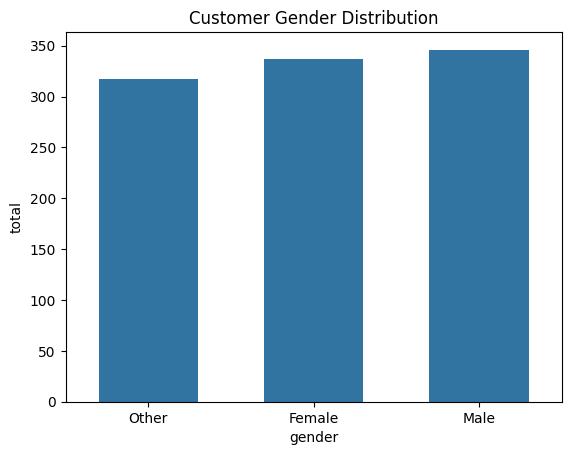

In [17]:
sns.barplot(data=df_gender, x='gender', y='total',width = 0.6)
plt.title('Customer Gender Distribution')
plt.show()

### 📊 ***Visual Insight: Customer Gender Distribution***
- The bank has a fairly even gender distribution among Male, Female, and Other categories.

- Slightly higher male representation is observed.

- The presence of the "Other" category shows inclusiveness — a ***good sign*** for diversity.

- No strong gender imbalance, indicating **neutral acquisition strategies** across demographics.

#### 📌Age Distribution

In [20]:
query = """
SELECT cleaned_name as name,age FROM aligned_customers_ws
WHERE age IS NOT NULL;
"""
df_age = pd.read_sql(query, engine)
df_age

,name,age
0,Allison Hill,69
1,Noah Rhodes,32
2,Angie Henderson,78
3,Daniel Wagner,38
4,Cristian Santos,41
...,...,...
995,Brittany Ward,21
996,Edward Stanley,43
997,Christina Johnson,75
998,Edgar Miller,46


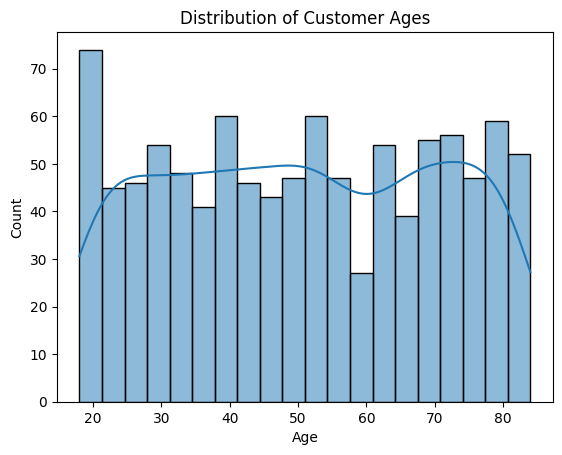

In [21]:
sns.histplot(df_age['age'], bins=20, kde=True)
plt.title('Distribution of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### 🧓 Visual Insight: Distribution of Customer Ages
- The customer base spans a wide age range from 18 to 85.

- There is a **uniform** spread across age groups with no sharp skew.

- Slight **peaks** are observed around the 20s, 40s, and 70s, indicating **active participation** from both **younger and senior customers**.

- This age diversity suggests the bank serves a balanced demographic, suitable for **offering a variety of products** — from youth savings to retirement plans.

#### 📌Average Age per Branch

In [22]:
query = """
SELECT b.branch_name, ROUND(AVG(c.age), 1) AS avg_age
FROM aligned_customers_ws c
JOIN branches b ON c.branch_id = b.branch_id
GROUP BY b.branch_name
ORDER BY avg_age DESC;
"""
df_age_branch = pd.read_sql(query, engine)
df_age_branch

,branch_name,avg_age
0,East Billy Branch,52.4
1,Karenchester Branch,52.2
2,Soniatown Branch,52.1
3,Latoyaland Branch,51.6
4,Anthonymouth Branch,51.0
5,Kimberlyton Branch,50.9
6,New Randy Branch,50.6
7,Halltown Branch,49.8
8,Christophermouth Branch,49.0
9,Lake Mercedes Branch,47.4


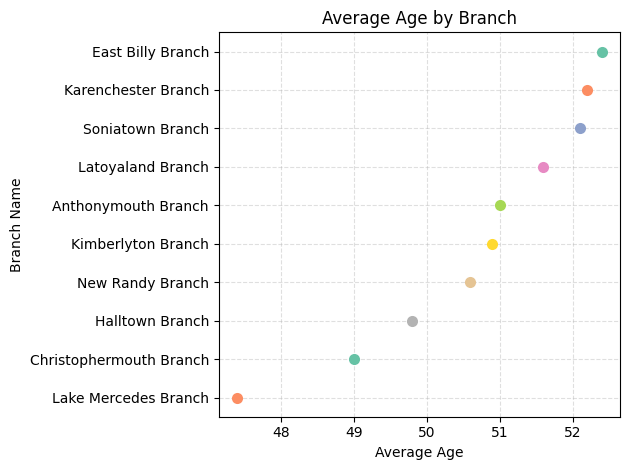

In [23]:
sns.stripplot(data=df_age_branch, x='avg_age', y='branch_name', jitter=True, size=8, hue = 'branch_name' ,palette='Set2')
plt.title('Average Age by Branch')
plt.xlabel('Average Age')
plt.ylabel('Branch Name')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 📊 Visual Insights: Average Customer Age by Branch

🎯 Most branches have an average customer age between 50 and 52 years, indicating a mature, financially active clientele.

🧓 East Billy Branch and Karenchester Branch have the highest average ages, suggesting they may cater more to senior or long-term customers.

👶 Lake Mercedes Branch shows the lowest average age (~47) — potentially serving younger or newly onboarded customers.

📌 This age spread is valuable for targeted product offerings — e.g., retirement plans in older branches, savings plans in younger ones.

## ⌨📑 Account-Level Analysis

#### 📌 Total balance by account type

In [24]:
query = """
SELECT account_type, ROUND(SUM(balance), 2) AS total_balance
FROM aligned_account_ws
GROUP BY 1 ORDER BY 2 DESC;
"""
df_balance = pd.read_sql(query, engine)
df_balance

,account_type,total_balance
0,Saving,30376929.10
1,Current,30364364.76
2,Loan,27339505.41
3,FD,25576391.09


Text(0.5, 1.0, 'Total Balance by Account Type')

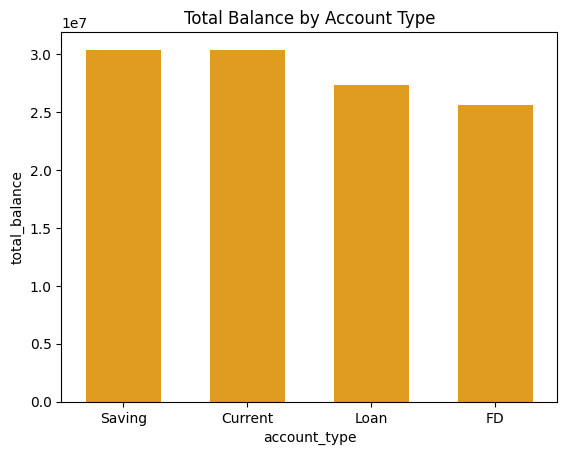

In [26]:
sns.barplot(x='account_type', y='total_balance',color='orange',width = 0.6,data=df_balance)
plt.title("Total Balance by Account Type")

#### 📌 Customers with both loan and credit card

In [28]:
query = """
        select t1.name , t2.loan_amount , credit_card 
        from aligned_customers_ws as t1
        join aligned_account_ws as t2 on t1.customer_id = t2.customer_id 
        where loan_amount <>0 and t2.credit_card  = 'Yes'
        order by name 
        ;
        """
both = pd.read_sql(query, engine)
print(f"Total Customers with both loan & credit_card: {len(both)}")
both.head()

Total Customers with both loan & credit_card: 49


,name,loan_amount,credit_card
0,Aimee Montoya,936544,Yes
1,Alyssa Day,615895,Yes
2,Angela Lopez,678583,Yes
3,Angela Lopez,678583,Yes
4,Angie Henderson,877843,Yes


## Credited and Debited Amount per Customer

In [30]:
query = """
SELECT customer_id,
SUM(CASE WHEN transaction_type = 'Credit' THEN amount ELSE 0 END) AS total_credit,
SUM(CASE WHEN transaction_type = 'Debit' THEN amount ELSE 0 END) AS total_debit
FROM aligned_transaction_ws
GROUP BY customer_id
order by total_credit desc;
"""
df_credit_debit = pd.read_sql(query, engine)
print("\n💰 Credit vs Debit per Customer:")
print(df_credit_debit.head())


💰 Credit vs Debit per Customer:
  customer_id  total_credit  total_debit
0  CUST000044     964498.32    295985.52
1  CUST000106     906409.19    425731.99
2  CUST000251     898418.56    555286.59
3  CUST000050     878544.75    444275.39
4  CUST000218     814316.14    481677.11


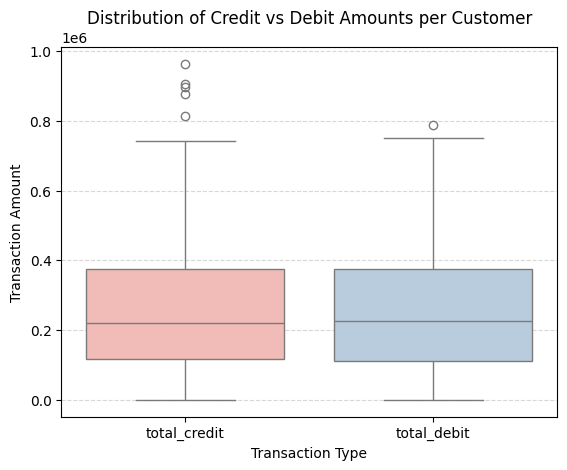

In [31]:
# Boxplot to compare credit and debit distributions

melted = pd.melt(df_credit_debit, id_vars='customer_id', value_vars=['total_credit', 'total_debit'],
                 var_name='Transaction Type', value_name='Amount')
sns.boxplot(data=melted, x='Transaction Type', y='Amount',hue = 'Transaction Type', palette='Pastel1', legend = False)
plt.title("Distribution of Credit vs Debit Amounts per Customer")
plt.ylabel("Transaction Amount")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 💡Visual Insights:


- Most customers have total credited and debited amounts under ₹400,000.
- A few outliers show total credit or debit amounts approaching ₹1 million, ***which may require further investigation.***
- The similar spread in both boxes indicates a balanced credit-debit profile across the customer base.
- This plot highlights the range and outliers in total credited and debited amounts.
- ***Helps identify unusually high activity*** in either transaction type.

## 🌟 Top 5 Customers with Highest Loan Amount

In [32]:
query = """
SELECT t1.name , t2.loan_amount,balance
FROM aligned_customers_ws AS t1
JOIN aligned_account_ws AS t2 ON t1.customer_id = t2.customer_id
ORDER BY loan_amount DESC 
LIMIT 5;
"""
df_top_loans = pd.read_sql(query, engine)
print(df_top_loans)

                 name  loan_amount      balance
0       Denise Jacobs       938710  178259.4841
1       Aimee Montoya       936544  481131.2390
2        Karen Graham       911689  475143.8221
3  Mrs. Kristen Reyes       903057  219281.4722
4    Cassandra Gaines       883482  109701.6438


### 💡 Visual Insight

All top 5 customers hold loans close to ₹900,000, suggesting either:

- They are premium or high-credit clients, or

- There may be a loan cap or credit limit that most ***top borrowers*** hit.

- The loan distribution is tightly packed, with only small variation among the top borrowers — ***indicating a concentrated high-value lending segment***.

- These individuals are high-impact accounts — ***monitoring their repayment behavior*** is crucial for credit risk   management.

These customers contribute significantly to the loan portfolio which is indeed useful for prioritizing high-value loan account management.

 #### 💼💰💳 Customers with Multiple Accounts

In [33]:
query = """
select customer_id , round(sum(balance),2) as total_balance , count(account_type) as no_of_accounts
from aligned_account_ws
group by 1
having no_of_accounts>1
order by 3 desc,2 desc
;
"""
df_multi_ac = pd.read_sql(query, engine)
print("\n👥 Customers with Multiple Accounts:")
# df_multi_ac.head()
df_multi_ac


👥 Customers with Multiple Accounts:


,customer_id,total_balance,no_of_accounts
0,CUST000264,1729713.14,4
1,CUST000162,1324720.11,4
2,CUST000240,1322964.70,4
3,CUST000002,1082045.75,4
4,CUST000087,1065286.21,4
...,...,...,...
135,CUST000280,55999.83,2
136,CUST000040,53619.86,2
137,CUST000197,50293.32,2
138,CUST000184,22136.33,2


####  Customer Count per Account Type

In [34]:
query = """
SELECT account_type, COUNT(DISTINCT customer_id) AS no_of_customers
FROM aligned_account_ws
GROUP BY 1
ORDER BY no_of_customers DESC;
"""
df_cust_per_type = pd.read_sql(query, engine)
print("🔢 Customers per Account Type:")
print(df_cust_per_type)

🔢 Customers per Account Type:
  account_type  no_of_customers
0         Loan              131
1       Saving              131
2      Current              128
3           FD              114


#### Number of Accounts per Scheme

In [35]:
query = """
SELECT scheme, COUNT(account_id) AS no_of_accounts
FROM aligned_account_ws
GROUP BY 1
ORDER BY no_of_accounts DESC;
"""
df_scheme_count = pd.read_sql(query, engine)
print("\n📂 Number of Accounts by Scheme:")
print(df_scheme_count)


📂 Number of Accounts by Scheme:
     scheme  no_of_accounts
0      Gold             126
1  Standard             113
2  Platinum             103
3    Senior             103
4      None              59


#### 🔽 Least Popular Account Type per Branch

In [37]:
query = """
WITH cte AS (
    SELECT t1.branch_name, t3.account_type AS least_account_type,
           COUNT(account_type) AS acc_count,
           ROW_NUMBER() OVER (PARTITION BY t1.branch_name ORDER BY COUNT(account_type)) AS rn
    FROM branches AS t1
    LEFT JOIN aligned_customers_ws AS t2 ON t1.branch_id = t2.branch_id
    JOIN aligned_account_ws AS t3 ON t2.customer_id = t3.customer_id
    GROUP BY 1, 2
)
SELECT branch_name, least_account_type
FROM cte
WHERE rn = 1;
"""
df_least_popular = pd.read_sql(query, engine)
print("\n 🔽 Least Popular Account Type per Branch:")
print(df_least_popular)


 🔽 Least Popular Account Type per Branch:
               branch_name least_account_type
0      Anthonymouth Branch            Current
1  Christophermouth Branch             Saving
2        East Billy Branch             Saving
3          Halltown Branch                 FD
4      Karenchester Branch             Saving
5       Kimberlyton Branch            Current
6     Lake Mercedes Branch             Saving
7        Latoyaland Branch                 FD
8         New Randy Branch               Loan
9         Soniatown Branch               Loan


## 💰💳💸 Transaction-Level Analysis 

 #### Customers Active in Last 30 Days 

In [39]:
query = """
SELECT t1.customer_id, t1.cleaned_name, t2.transaction_type, t2.formatted_date
FROM aligned_customers_ws AS t1
JOIN aligned_transaction_ws AS t2 ON t1.customer_id = t2.customer_id
WHERE formatted_date >= (SELECT MAX(formatted_date) - INTERVAL 30 DAY FROM aligned_transaction_ws);
"""
df_recent_txns = pd.read_sql(query, engine)
print("\n 📅 Active Customers (Last 30 Days):")
print(df_recent_txns.head())


 📅 Active Customers (Last 30 Days):
  customer_id     cleaned_name transaction_type formatted_date
0  CUST000001     Allison Hill           Credit     2025-04-14
1  CUST000006  Connie Lawrence           Credit     2025-05-04
2  CUST000007  Abigail Shaffer            Debit     2025-04-26
3  CUST000008       Gina Moore           Credit     2025-05-09
4  CUST000012     Jamie Arnold           Credit     2025-04-20


#### 📌 Monthly Transaction volume in 2024

In [40]:
query = """
        select monthname(formatted_date) as 2024_month,round(sum(amount),2) as total_amount
        from aligned_transaction_ws
        where year(formatted_date) = year(curdate()) -1  
        #2024 -- or -- where year(formatted_date) = 2024
        group by month(formatted_date),  monthname(formatted_date) 
        order by 2 desc
        ;
        """
df_txn_monthly = pd.read_sql(query, engine)
df_txn_monthly

,2024_month,total_amount
0,September,7255457.10
1,March,7208970.13
2,May,7014506.91
3,July,6413262.41
4,January,6022297.45
5,August,5897329.60
6,November,5738518.85
7,June,5586523.28
8,December,5504892.76
9,April,5426928.72


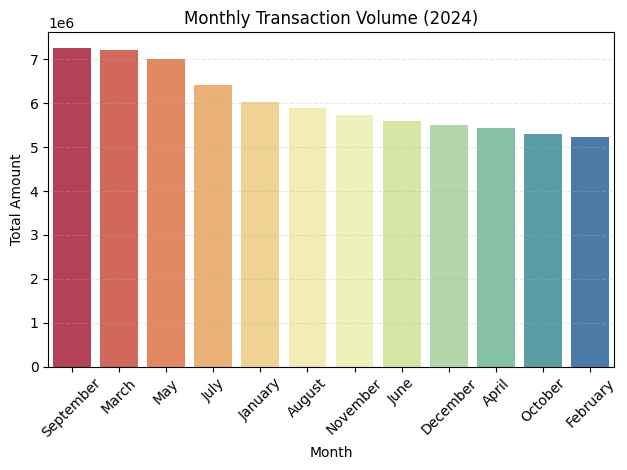

   2024_month  total_amount
0   September    7255457.10
1       March    7208970.13
2         May    7014506.91
3        July    6413262.41
4     January    6022297.45
5      August    5897329.60
6    November    5738518.85
7        June    5586523.28
8    December    5504892.76
9       April    5426928.72
10    October    5308085.99
11   February    5240394.92


In [41]:
df_sorted = df_txn_monthly.sort_values('total_amount', ascending=False)

sns.barplot(data=df_sorted, x='2024_month', y='total_amount',hue = '2024_month', palette='Spectral')
plt.title("Monthly Transaction Volume (2024)")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.xticks(rotation=45)

# # Highlight spike
# max_amt = df_sorted['total_amount'].max()
# max_month = df_sorted[df_sorted['total_amount'] == max_amt]['2024_month'].values[0]
# plt.text(max_month, max_amt + 100000, "Peak", ha='center', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
print(df_txn_monthly)

## 💡 Visual Insights:

 ***The chart reveals significant variation in monthly transaction volumes, with clear seasonal peaks and dips***.

🔍 Months like September or December ***highlight peak transaction*** periods, possibly due to:

- Salary cycles

- Festive season spikes (e.g., Diwali, Christmas)

- Financial year-end activity

🔍 Months like February, April, and October ***dip to lower banking engagement***, possibly due to:

- Fewer working days (e.g., holidays, year-start)

- Post-festival slowdowns

- Customer disengagement or account dormancy

#### High-value transactions per month (2025)

In [42]:
query = """
        with cte as 
        (
        	select t1.transaction_id, substring_index(t2.cleaned_name,' ',1) as first_name , t1.amount,monthname(formatted_date) as 2025_month,
        	row_number() over (partition by month(formatted_date) order by (t1.amount)desc) as rn
        	from aligned_transaction_ws as t1 
        	join aligned_customers_ws as t2 on t1.customer_id = t2.customer_id 
        	where amount > 90000 
        	and (year(formatted_date) = '2025')
        )
        select transaction_id, first_name , amount,2025_month
        from cte 
        where rn = 1
        ;
      """
monthly_transaction = pd.read_sql(query, engine)
monthly_transaction

,transaction_id,first_name,amount,2025_month
0,TXN20250126-0000308,Stephanie,99894.17,January
1,TXN20250202-0002994,Elaine,99801.60,February
2,TXN20250313-0000232,Brian,99226.78,March
3,TXN20250405-0002369,Michelle,99749.14,April
4,TXN20250511-0000450,John,99100.15,May


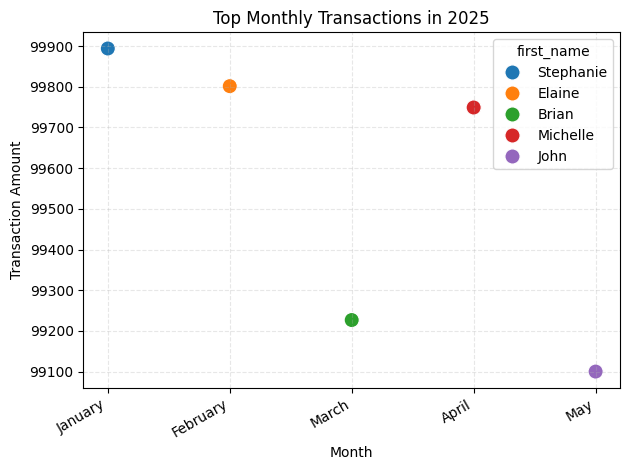


📈 Highest Transactions per Month (2025):
        transaction_id first_name    amount 2025_month
0  TXN20250126-0000308  Stephanie  99894.17    January
1  TXN20250202-0002994     Elaine  99801.60   February
2  TXN20250313-0000232      Brian  99226.78      March
3  TXN20250405-0002369   Michelle  99749.14      April
4  TXN20250511-0000450       John  99100.15        May


In [43]:
# Scatter plot of high-value transactions by month
sns.scatterplot(data=monthly_transaction, x='2025_month', y='amount', hue='first_name', palette='tab10', s=120,legend= True)


# # Annotate customer names on each point
# for i, row in monthly_transaction.iterrows():
#     plt.text(row['2025_month'], row['amount'] - 42, row['first_name'],
#              ha='left', fontsize=9, rotation=15)


plt.title("Top Monthly Transactions in 2025")
plt.xlabel("Month")
plt.ylabel("Transaction Amount")
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


print("\n📈 Highest Transactions per Month (2025):")
print(monthly_transaction)

## 💡 Visual Insights
- This scatter plot helps identify whether certain months saw spikes in high-value transactions.
- Useful for seasonal trend analysis and risk exposure review.



## 🔼 Customer with Highest Single Transaction

In [44]:
query = """
SELECT t2.transaction_id, t1.name, t2.amount
FROM aligned_customers_ws AS t1
JOIN aligned_transaction_ws AS t2 ON t1.customer_id = t2.customer_id
ORDER BY t2.amount DESC
# LIMIT 1
;
"""
df_top_single_txn = pd.read_sql(query, engine)
print("💸 Highest Single Transaction:")
print(df_top_single_txn)

💸 Highest Single Transaction:
           transaction_id               name    amount
0     TXN20240709-0002782        Noah Rhodes  99977.45
1     TXN20240804-0001447  David Douglas Jr.  99951.82
2     TXN20250126-0000308  Stephanie Manning  99894.17
3     TXN20240521-0002691        James Brown  99892.26
4     TXN20230617-0001285     Sandra Aguilar  99877.94
...                   ...                ...       ...
2995  TXN20240219-0002599         Fred Smith    203.71
2996  TXN20241128-0002399       Amber Wright    201.55
2997  TXN20230726-0000006       Victor Baker    170.26
2998  TXN20231213-0001093       Tina Sanders    133.44
2999  TXN20230731-0000236      Shannon James    106.49

[3000 rows x 3 columns]


## Customer Behavior Patterns

#### 📌 Inactive customers (90+ days)

In [45]:
# Latest Date:
query = """
        select max(formatted_date) as Latest_date 
        from aligned_transaction_ws ; -- 2025-05-12
        """
max_date = pd.read_sql(query,engine)
max_date

,Latest_date
0,2025-05-12


In [46]:
# 90 day Transaction Date:
query = """
        SELECT date_sub(MAX(formatted_date), interval 90 day) as Quarterly_Date
        FROM aligned_transaction_ws; -- 2025-02-11
        """
max_date = pd.read_sql(query,engine)
max_date

,Quarterly_Date
0,2025-02-11


In [48]:
#Query as per the statement:

query = """
  select t1.customer_id , t1.cleaned_name , t2.account_id  ,branch_name,round(t2.balance,2) as balance,t4.formatted_date
from aligned_customers_ws as t1
join aligned_account_ws as t2 on t1.customer_id = t2.customer_id 
join branches as t3 on t1.branch_id = t3.branch_id  
left join aligned_transaction_ws as t4 on t1.customer_id = t4.customer_id and t2.account_id = t2.account_id
and t4.formatted_date >= (select date_sub(max(t4.formatted_date),interval 90 day) from aligned_transaction_ws)
where t4.transaction_id is null 
order by t1.customer_id 
;
    """
inactive_counts =pd.read_sql(query, engine)
inactive_counts.head()

,customer_id,cleaned_name,account_id,branch_name,balance,formatted_date
0,CUST000031,Rebecca Henderson,SAV000000011,Halltown Branch,118957.04,2025-03-25
1,CUST000037,Sherri Baker,CUR000000009,Karenchester Branch,397863.52,2025-03-07
2,CUST000037,Sherri Baker,LOA000000016,Karenchester Branch,99886.68,2025-03-07
3,CUST000037,Sherri Baker,FD000000014,Karenchester Branch,247696.38,2025-03-07
4,CUST000042,Fred Smith,CUR000000010,Halltown Branch,116657.03,2025-03-08


## Visual Insights
- Helps detect branches with disengaged customers..
- Can guide re-engagement or retention campaigns where inactivity is highest:
- 🎯 Retention Campaign Ideas by Branch based on high inactivity counts from the plots:

1. Reactivation Offers
 
***What***: Personalized incentives to return (e.g., ₹500 cash-back on next transaction).

***Why***: Encourages dormant customers to use services again.

2. Targeted Communication
   
***What***: Email/SMS/app push reminding them of benefits (e.g., no-fee accounts, new features).

***Why***: Rekindles attention, especially for customers who haven’t transacted in 90+ days.

📞 Customer Support Call High-value inactive customers can be contacted to understand their reason for churn.


## 📈 Branch Performance 

#### Customer Info + Branch Size 

In [49]:
query = """
WITH branch_counts AS (
    SELECT t1.branch_id, COUNT(DISTINCT t3.customer_id) AS branch_size
    FROM branches AS t1
    LEFT JOIN aligned_customers_ws AS t3 ON t1.branch_id = t3.branch_id
    GROUP BY t1.branch_id
)
SELECT t1.customer_id, t1.cleaned_name, t2.account_type, t3.branch_name, b.branch_size
FROM aligned_customers_ws AS t1
LEFT JOIN aligned_account_ws AS t2 ON t1.customer_id = t2.customer_id
JOIN branches AS t3 ON t1.branch_id = t3.branch_id
JOIN branch_counts AS b ON t3.branch_id = b.branch_id
ORDER BY b.branch_size DESC;
"""
df_branch_size = pd.read_sql(query, engine)
print("\n 📋 Customer Info with Branch Size:")
df_branch_size


 📋 Customer Info with Branch Size:


,customer_id,cleaned_name,account_type,branch_name,branch_size
0,CUST000005,Cristian Santos,FD,East Billy Branch,110
1,CUST000010,Ryan Munoz,FD,East Billy Branch,110
2,CUST000014,Michele Williams,Current,East Billy Branch,110
3,CUST000022,Patty Perez,Loan,East Billy Branch,110
4,CUST000045,Angelica Tucker,Loan,East Billy Branch,110
...,...,...,...,...,...
1211,CUST000940,Curtis Wilkerson,None,Anthonymouth Branch,84
1212,CUST000961,Erica Johnson,None,Anthonymouth Branch,84
1213,CUST000967,Marie Thompson,None,Anthonymouth Branch,84
1214,CUST000970,Eric Barker,None,Anthonymouth Branch,84


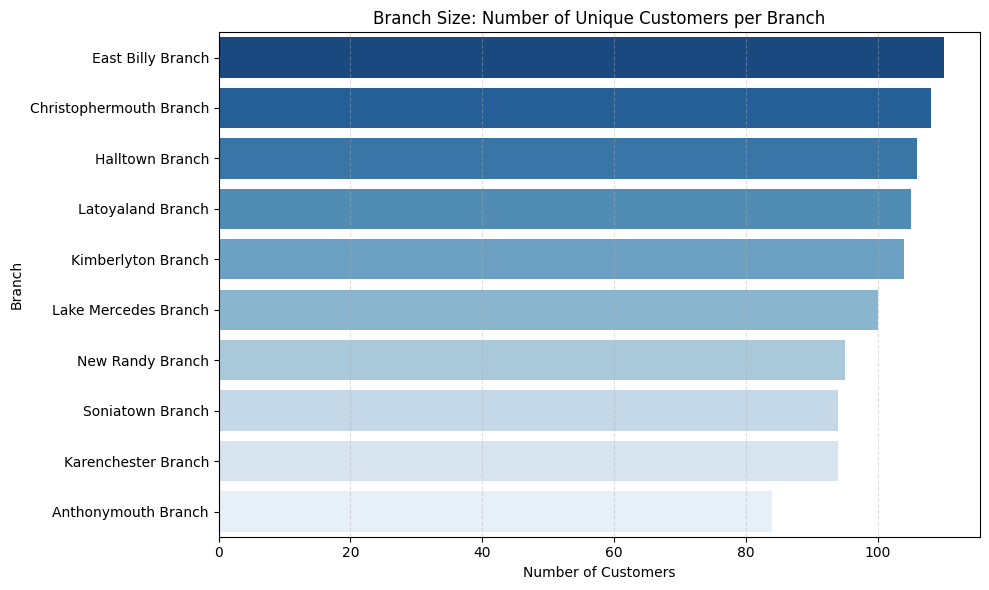

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_branch_size, x='branch_size', y='branch_name', hue='branch_name', palette='Blues_r',legend=False)
plt.title("Branch Size: Number of Unique Customers per Branch")
plt.xlabel("Number of Customers")
plt.ylabel("Branch")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### 📌 Branch with most active customers

In [51]:
query = """with highest_active_customers as 
(
	select t2.branch_name, count(distinct t1.customer_id) as highest_active_customers ,
	rank() over(order by count(distinct t1.customer_id)desc) as `rank`
	from aligned_customers_ws as t1
	join branches  as t2 on t1.branch_id = t2.branch_id 
	join aligned_transaction_ws as t3 on t1.customer_id = t3.customer_id 
	where formatted_date >= (select max(formatted_date) - interval 30 day from aligned_transaction_ws ) #noting for active customers
	group by 1
	limit 1 
) 
select * from highest_active_customers
;
"""
active_customers = pd.read_sql(query, engine)
active_customers

,branch_name,highest_active_customers,rank
0,East Billy Branch,15,1


#### Branch with Highest Transaction Amount

In [52]:
query = """
SELECT t1.branch_name , MAX(t3.amount) AS highest_amount, t2.cleaned_name 
FROM branches AS t1
LEFT JOIN aligned_customers_ws AS t2 ON t1.branch_id = t2.branch_id 
JOIN aligned_transaction_ws AS t3 ON t2.customer_id = t3.customer_id 
JOIN aligned_account_ws AS t4 ON t1.branch_id = t4.branch_id
GROUP BY 1,3
ORDER BY highest_amount DESC
LIMIT 1;
"""
df_top_branch = pd.read_sql(query, engine)
print("\n🏦 Branch with Highest Transaction:")
df_top_branch


🏦 Branch with Highest Transaction:


,branch_name,highest_amount,cleaned_name
0,Soniatown Branch,99977.45,Noah Rhodes


#### 📌 Branch loan & balance stats

In [53]:
query = """
        select branch_name,round(avg(t1.balance),2) as avg_balance, round(sum(t1.loan_amount),2) as total_loan_amount
        from aligned_account_ws as t1 
        join aligned_customers_ws as t2 on t1.customer_id = t2.customer_id 
        join branches as t3 on t2.branch_id = t3.branch_id 
        group by 1
        order by 2 desc ,3 desc
        ;
        """
branch_stats = pd.read_sql(query, engine)
branch_stats

,branch_name,avg_balance,total_loan_amount
0,Kimberlyton Branch,254816.71,3904266.0
1,Latoyaland Branch,243509.34,5837933.0
2,Soniatown Branch,230678.87,4548977.0
3,Anthonymouth Branch,229859.10,7546234.0
4,Karenchester Branch,228075.37,5818203.0
5,Christophermouth Branch,225566.03,5682995.0
6,East Billy Branch,223860.19,4382153.0
7,Halltown Branch,218634.60,4502123.0
8,New Randy Branch,214943.53,4938786.0
9,Lake Mercedes Branch,197150.79,5358800.0


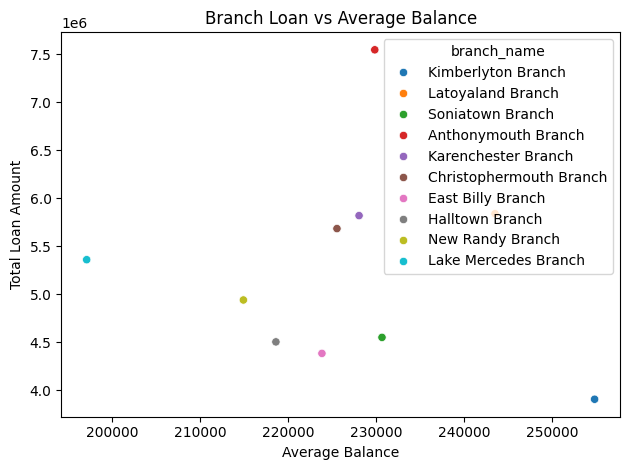

               branch_name  avg_balance  total_loan_amount
0       Kimberlyton Branch    254816.71          3904266.0
1        Latoyaland Branch    243509.34          5837933.0
2         Soniatown Branch    230678.87          4548977.0
3      Anthonymouth Branch    229859.10          7546234.0
4      Karenchester Branch    228075.37          5818203.0
5  Christophermouth Branch    225566.03          5682995.0
6        East Billy Branch    223860.19          4382153.0
7          Halltown Branch    218634.60          4502123.0
8         New Randy Branch    214943.53          4938786.0
9     Lake Mercedes Branch    197150.79          5358800.0


In [54]:
# Scatter plot
sns.scatterplot(data=branch_stats, x='avg_balance', y='total_loan_amount', hue = 'branch_name', palette='tab10')
plt.title("Branch Loan vs Average Balance")
plt.xlabel("Average Balance")
plt.ylabel("Total Loan Amount")

# # Add branch name labels
# for i in range(len(branch_stats)):
#     plt.text(
#         x=branch_stats['avg_balance'][i], 
#         y=branch_stats['total_loan_amount'][i], 
#         s=branch_stats['branch_name'][i],
#         fontsize=7,
#         ha='left',
#         va='bottom'
#     )

plt.tight_layout()
plt.show()
print(branch_stats)

### 💡 Visual Insights:

- Most branches seem to follow a moderate positive trend — higher average balances tend to be associated with higher total loan issuance.

***However, there are a few outliers:***

- ***Kimberlyton Branch*** branch with very high average balance has issued relatively low total loans — suggesting it holds wealthy depositors who are not borrowing much.

- ***Anthonymouth Branch*** with moderate average balance has issued the highest total loan amount, possibly indicating high credit exposure relative to deposits.

***This graph can help identify:***

- Underutilized branches (high balances but low lending)

- High-risk branches (lower balances but aggressive loan issuance)

#### Customer-Balance Rank Within Branch

In [125]:
query = """
        SELECT t1.customer_id, t1.cleaned_name, t3.branch_name, ROUND(t2.balance,2) AS balance,
        RANK() OVER (PARTITION BY t3.branch_name ORDER BY t2.balance DESC) AS branch_rank
        FROM aligned_customers_ws AS t1
        JOIN aligned_account_ws AS t2 ON t1.customer_id = t2.customer_id
        JOIN branches AS t3 ON t2.branch_id = t3.branch_id
        ;
        """
df_branch_rank = pd.read_sql(query, engine)
print("\n🥇 Balance Rank Within Branch:")
# print(df_branch_rank.head())
df_branch_rank


🥇 Balance Rank Within Branch:


,customer_id,cleaned_name,branch_name,balance,branch_rank
0,CUST000053,Crystal Robinson,Anthonymouth Branch,498117.26,1
1,CUST000235,Michael Lyons,Anthonymouth Branch,477167.41,2
2,CUST000106,Marc Moore,Anthonymouth Branch,467537.22,3
3,CUST000106,Marc Moore,Anthonymouth Branch,466951.89,4
4,CUST000113,Julia Torres,Anthonymouth Branch,444229.07,5
...,...,...,...,...,...
499,CUST000152,Pamela Boyd,Soniatown Branch,33372.05,57
500,CUST000055,Shannon Jones,Soniatown Branch,29771.91,58
501,CUST000068,Carol Tucker,Soniatown Branch,24414.25,59
502,CUST000197,Daniel Salinas,Soniatown Branch,10101.92,60


### 🏆Top Rank Customers Per Branch

In [56]:
query = '''
            with cte as
            (
            	select t.customer_id, t.cleaned_name, t.branch_name, t.balance, row_number()over(partition by branch_name order by `rank`) as top_branchRank_Customers
            	from 
            	(
            		select t1.customer_id, t1.cleaned_name ,t3.branch_name, round(t2.balance,2) as balance,
            		rank()over(partition by t3.branch_name order by (t2.balance)desc) as `rank`
            		from aligned_customers_ws as t1
            		join aligned_account_ws as t2 on t1.customer_id = t2.customer_id 
            		join branches as t3 on t2.branch_id = t3.branch_id 
            		-- where t1.customer_id = 'CUST000219'
            	) as t
            )
            select * from cte where top_branchRank_Customers = 1
            	; 
    '''
Top_Rankers = pd.read_sql(query,engine)
Top_Rankers

,customer_id,cleaned_name,branch_name,balance,top_branchRank_Customers
0,CUST000053,Crystal Robinson,Anthonymouth Branch,498117.26,1
1,CUST000117,William Herrera,Christophermouth Branch,483216.13,1
2,CUST000014,Michele Williams,East Billy Branch,488733.41,1
3,CUST000261,Katie Suarez,Halltown Branch,488869.07,1
4,CUST000162,Jennifer Adkins,Karenchester Branch,498897.20,1
5,CUST000090,Aimee Montoya,Kimberlyton Branch,481131.24,1
6,CUST000275,Joyce Bowen,Lake Mercedes Branch,486506.08,1
7,CUST000254,Barbara Dudley,Latoyaland Branch,481159.86,1
8,CUST000083,Michael Evans,New Randy Branch,499783.27,1
9,CUST000193,Debra Christian,Soniatown Branch,495851.06,1


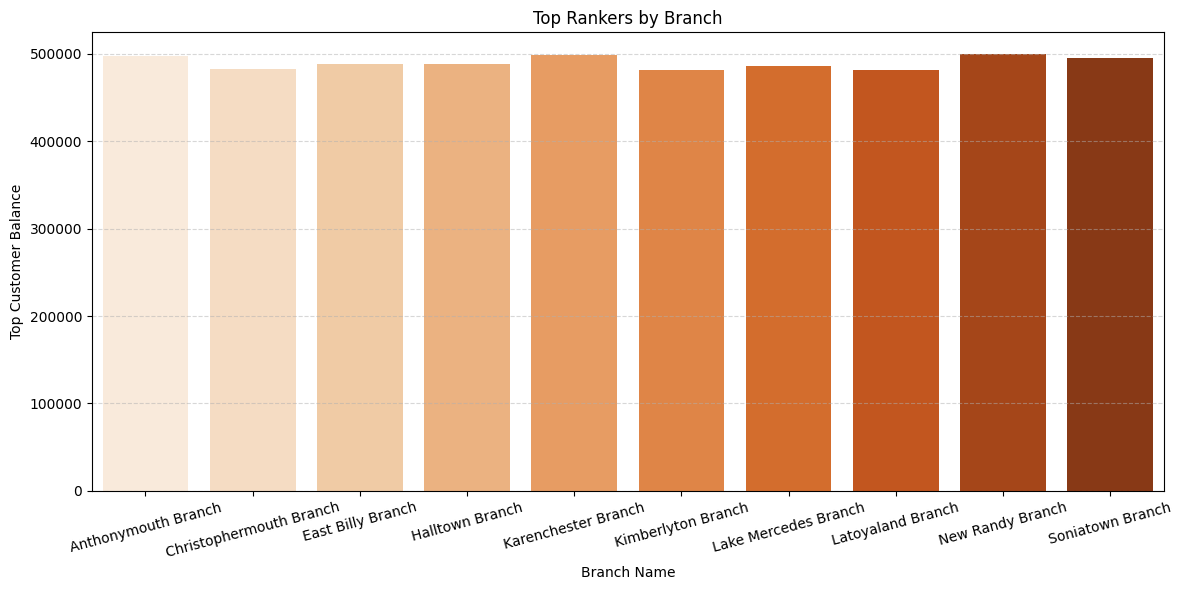

In [65]:
# Create barplot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Top 1 customer per branch (replace this with your actual SQL result)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=Top_Rankers,
    x='branch_name',
    y='balance',
    hue='cleaned_name',
    width=0.8, 
    dodge=False,
    palette='Oranges'  # consistent orange tone
)

# Styling
plt.title("Top Rankers by Branch")
plt.xlabel("Branch Name")
plt.ylabel("Top Customer Balance")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend([], [], frameon=False)  # hides hue legend
plt.tight_layout()
plt.show()

#### Branches with >50% Inactive Customers 

In [66]:
query = """
SELECT b.branch_name,
    COUNT(DISTINCT c.customer_id) AS total_customers,
    COUNT(DISTINCT t.customer_id) AS active_customers,
    COUNT(DISTINCT c.customer_id) - COUNT(DISTINCT t.customer_id) AS inactive_customers
FROM branches b
JOIN aligned_customers_ws c ON b.branch_id = c.branch_id
LEFT JOIN aligned_transaction_ws t ON c.customer_id = t.customer_id
  AND t.formatted_date >= (SELECT DATE_SUB(MAX(formatted_date), INTERVAL 60 DAY) FROM aligned_transaction_ws)
GROUP BY b.branch_name
HAVING (COUNT(DISTINCT c.customer_id) - COUNT(DISTINCT t.customer_id)) > 0.5 * COUNT(DISTINCT c.customer_id);
"""
df_inactive_branches = pd.read_sql(query, engine)
print("\n🚩 Branches with >50% Inactive Customers:")
df_inactive_branches


🚩 Branches with >50% Inactive Customers:


,branch_name,total_customers,active_customers,inactive_customers
0,Anthonymouth Branch,84,15,69
1,Christophermouth Branch,108,21,87
2,East Billy Branch,110,22,88
3,Halltown Branch,106,16,90
4,Karenchester Branch,94,18,76
5,Kimberlyton Branch,104,10,94
6,Lake Mercedes Branch,100,18,82
7,Latoyaland Branch,105,9,96
8,New Randy Branch,95,16,79
9,Soniatown Branch,94,17,77


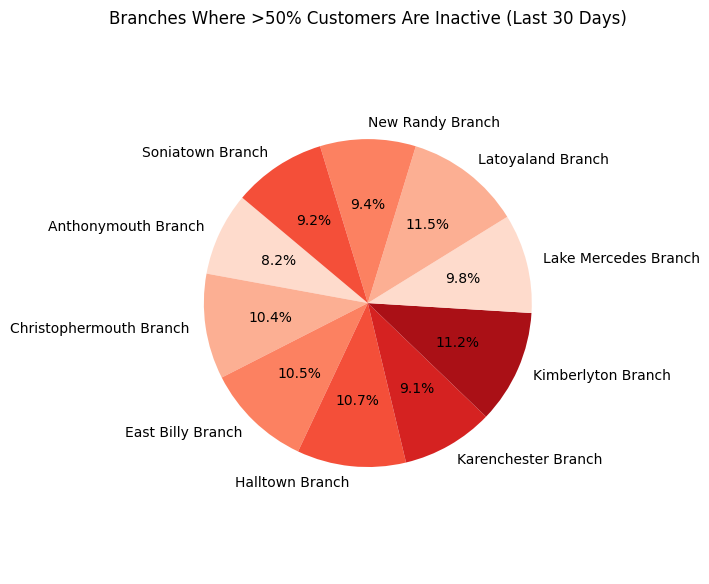

In [67]:
# inactive_branches = pd.read_sql(query, engine)

plt.figure(figsize=(7, 6))
plt.pie(df_inactive_branches['inactive_customers'],
        labels=df_inactive_branches['branch_name'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('Reds')[0:len(df_inactive_branches)])
plt.title("Branches Where >50% Customers Are Inactive (Last 30 Days)")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Visual Insights
🎯 Retention Campaign Ideas by Branch

1. Branch Manager Outreach

***What***: Top branches (with highest inactivity) can directly call or email top inactive accounts.

***Why***: Builds trust and a sense of personal service.

2. Feedback Request Campaign
   
***What***: Ask inactive users why they haven’t engaged recently through surveys.

***Why***: Shows interest and helps improve service offerings.

3. Gamified Re-entry
   
***What***: Points or badges for doing 3 actions in 30 days (e.g., balance check, bill pay, transfer).

***Why***: Makes engagement fun and habitual.

### Loan Ratio Per Customer:

In [68]:
query = """
        SELECT customer_id,cast(loan_balance_ratio as float) as loan_balance_ratio 
        FROM aligned_account_ws
        WHERE loan_balance_ratio is not null 
        ;
        """
df_loan_ratio = pd.read_sql(query, engine)
print("\n📈 Loan-to-Balance Ratio (Loan Ratio):")
# print(df_loan_ratio.head())
df_loan_ratio


📈 Loan-to-Balance Ratio (Loan Ratio):


,customer_id,loan_balance_ratio
0,CUST000001,0.20
1,CUST000026,1.48
2,CUST000060,1.19
3,CUST000084,7.15
4,CUST000106,1.70
...,...,...
100,CUST000127,6.80
101,CUST000182,0.34
102,CUST000280,9.36
103,CUST000240,0.99


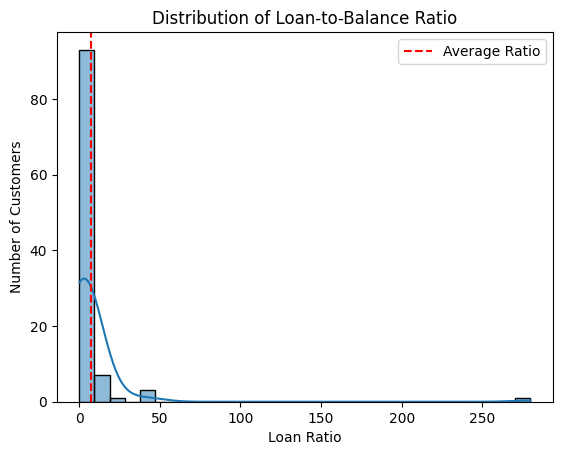

In [69]:
sns.histplot(df_loan_ratio['loan_balance_ratio'], bins=30, kde=True)
plt.title("Distribution of Loan-to-Balance Ratio")
plt.xlabel("Loan Ratio")
plt.ylabel("Number of Customers")
plt.axvline(df_loan_ratio['loan_balance_ratio'].mean(), color='red', linestyle='--', label='Average Ratio')
plt.legend()
plt.show()

### 🧠 Visual Insights

***(i)The first bar (left-most) has the highest count, which means:***
- Most customers have a low loan ratio typically under 1.0 — meaning they maintain more balance than loan, which is financially healthy.
  
***(ii)There are a few extreme outliers on the right (e.g., ratios > 50 or even 200), but their count is minimal.***
- A spike above 1.0 could indicate risk-prone customers relying heavily on loans.

***(iii)The average loan-to-balance ratio provides a benchmark for evaluating lending risk***
- This average acts as a threshold for credit risk teams to flag high-risk customers whose loan usage deviates significantly from the norm.

## CIBIL Score Distribution

In [70]:
query = '''
        select * from cibil_accounts;
        '''
df_cibil = pd.read_sql(query,engine)
df_cibil

,customer_id,loan_score,credit_score,balance_score,cibil_score,credit_rating
0,CUST000001,30,10,30,700,Good
1,CUST000002,30,10,30,700,Good
2,CUST000003,5,25,30,600,Fair
3,CUST000006,30,10,30,700,Good
4,CUST000007,30,10,30,700,Good
...,...,...,...,...,...,...
126,CUST000279,10,10,30,500,Fair
127,CUST000283,30,10,30,700,Good
128,CUST000285,30,10,30,700,Good
129,CUST000286,30,25,30,850,Excellent Rating


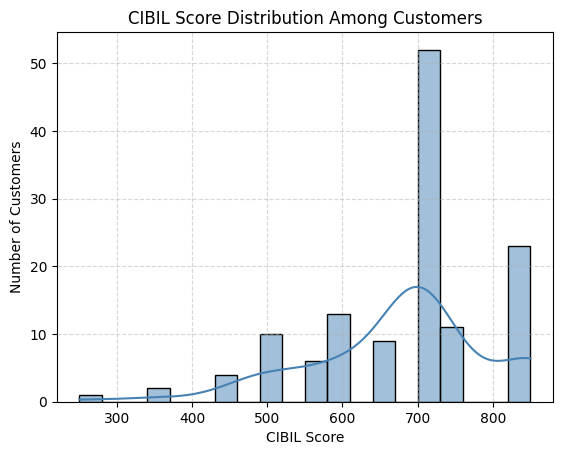

In [71]:
sns.histplot(df_cibil['cibil_score'], bins=20, kde=True, color='steelblue')
plt.title("CIBIL Score Distribution Among Customers")
plt.xlabel("CIBIL Score")
plt.ylabel("Number of Customers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 💡 Visual Insights:
- Most customers have CIBIL scores between 600 and 800.
- High scores (750+) suggest strong creditworthiness.
- A small tail on the low-score side may indicate risk-prone customers.

## Average Loan Amount by CIBIL Score Range:

In [72]:
query = """
SELECT 
  CASE 
    WHEN cibil_score >= 800 THEN 'Excellent (800+)' 
    WHEN cibil_score BETWEEN 750 AND 799 THEN 'Very Good (750-799)' 
    WHEN cibil_score BETWEEN 700 AND 749 THEN 'Good (700-749)' 
    WHEN cibil_score BETWEEN 650 AND 699 THEN 'Fair (650-699)' 
    ELSE 'Risky/Bad (<650)' 
  END AS score_band,
  ROUND(AVG(t2.loan_amount), 2) AS avg_loan,
  count(distinct t1.customer_id) as customer_count
  FROM cibil_accounts as t1
  join aligned_account_ws as t2 on t1.customer_id = t2.customer_id 
  GROUP BY score_band
  ORDER BY avg_loan DESC;
"""
df_cibil_band = pd.read_sql(query, engine)
print("\n 📊 Customers per CIBIL Score Band:")
# print(df_cibil_band)
df_cibil_band


 📊 Customers per CIBIL Score Band:


,score_band,avg_loan,customer_count
0,Fair (650-699),280924.29,9
1,Risky/Bad (<650),203102.42,36
2,Excellent (800+),82661.77,23
3,Good (700-749),47456.84,52
4,Very Good (750-799),0.00,11


### Customer Distribution by CIBIL Score Band

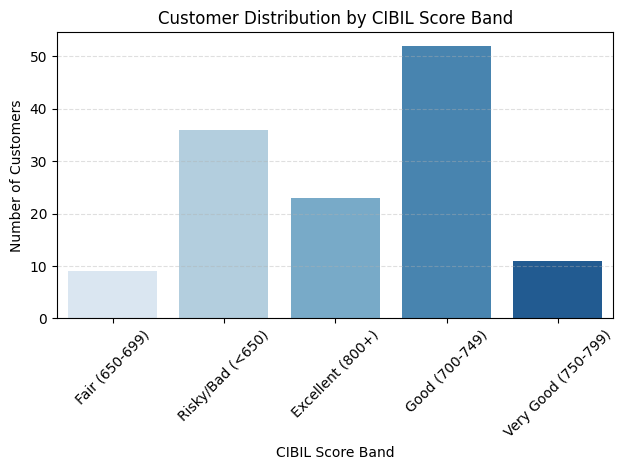

In [73]:
sns.barplot(data=df_cibil_band, x='score_band', y='customer_count', hue='score_band', palette='Blues', dodge=False, legend=False)
plt.title("Customer Distribution by CIBIL Score Band")
plt.ylabel("Number of Customers")
plt.xlabel("CIBIL Score Band")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
# plt.legend().set_visible(False)
plt.show()

## 💡 Visual Insights:
- Most customers fall in the 'Good (700–749)' and 'Risky/Bad (<650)' bands, with relatively fewer in 'Very Good' or 'Excellent'.
- This suggests limited representation to emphasize strategic opportunities around acquiring high-credit customers and supporting underserved groups.
- For the 'Risky/Bad' group, conservative loan policies or credit repair initiatives may help manage risk.
- This distribution helps in formulating credit policy and product targeting strategies aligned to score bands.

## Average Loan Amount by CIBIL Score Band

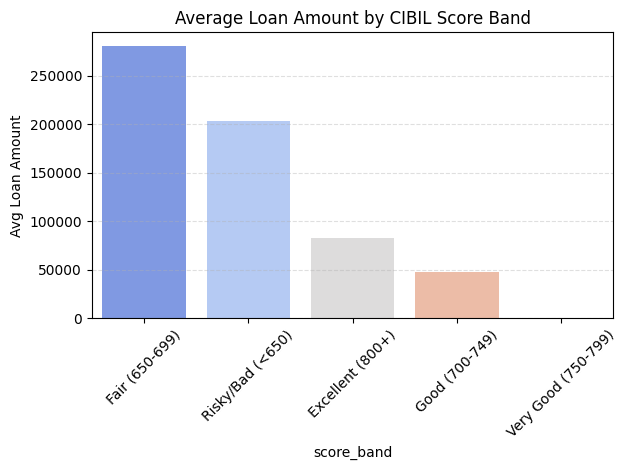

In [74]:
sns.barplot(data=df_cibil_band, x='score_band', y='avg_loan', hue= 'score_band',palette='coolwarm')
plt.title("Average Loan Amount by CIBIL Score Band")
plt.ylabel("Avg Loan Amount")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 💡Visual Insight:
- Higher CIBIL bands (750+) are generally associated with larger average loan amounts.
- However, in this dataset, the 'Fair' and 'Risky/Bad' bands show unusually high average loans, likely due to outliers or legacy approvals.
- This **anomaly** highlights the **importance of validating loan policy alignment with credit score segments**.
- Ideally, **lending limits** should **increase** with score bands to reflect **better risk management**.
- This validates CIBIL’s role as a creditworthiness indicator, but suggests policy review when inconsistencies appear.


## ✅ Conclusion: Insights from SQL-Powered Bank EDA:
This end-to-end SQL and Python exploratory data analysis (EDA) project delivered actionable insights into customer behavior, account patterns, and transaction dynamics in a banking ecosystem. Here's a final summary:

## 🔍 Key Discoveries:

1. **Account Behavior:**

- Majority of customers have either savings or loan accounts, with a noticeable proportion having no associated account — hinting at newly onboarded or inactive profiles.

- Certain branches show higher customer volumes but lower engagement or balance activity.

- **Credit Patterns:**

(i) Higher CIBIL score bands (800+) are generally linked with lower average loan amounts, possibly due to disciplined financial behavior or fewer borrowing needs.

(ii) Customers with mid-range scores (650–699) interestingly exhibited the highest average loan values, suggesting a targeted segment for lending products.

2. **Transaction Intelligence:**

- Identified peak transactions per month, with customer-wise tagging using scatter chart.

- High-frequency users (>5 transactions/day) were flagged — useful for monitoring churn risks or VIP behavior.

3. **Customer Inactivity:**

- Over 9 branches had >50% customer inactivity in the last 30 days, as revealed via pie chart — making them key targets for re-engagement or retention campaigns like:

📧 Email nudges for login/transaction.

💳 Personalized offers (fee waiver, bonus interest).

🧑‍💼 Relationship manager calls or onboarding of missing account types.

4.**Branch-Level Stats:**

- Analysis of average balances and total loans by branch showed diverse financial engagement — enabling branch-level performance tuning.



## 💾 Appendix

#### 📁 Data Sources
- This project uses **simulated banking data** designed to reflect realistic customer, account, and transaction behaviors. The dataset was **manually created and cleaned** to support exploratory analysis and SQL-based querying.

📌 **Note: No real customer information is used. All data is fully anonymized and created for educational purposes.**

#### 🔌 SQLAlchemy Setup
```python
from sqlalchemy import create_engine
engine = create_engine("mysql+pymysql://...")
```

#### 📊 Simulated Tables:
- `customers.csv`: Contains 1102 fictional customer records with demographic and contact details
- `accounts.csv`: Bank account types (e.g., SAV, FD, LOA) and balances per customer
- `transactions.csv`: Deposit, withdrawal, loan, and transfer activity logs
- `branches.csv`: Mapping of branch IDs to city/state names
- `cibil accounts.csv`: Contains customer CIBIL scores, credit limits, repayment history, and risk bands for credit profiling.

#### 🧰 Utility Functions
1. **Python Visualizations**

- matplotlib.pyplot (plt.): Used for setting titles, labels, gridlines, and layout

- seaborn (sns.): Used for producing high-level plots like barplots, scatterplots, histograms


2. **Domain-specific Calculations**

- Functions like:
  - calculate_loan_to_balance_ratio(df)
  - flag_inactive_customers(df)
  - generate_credit_score(df)

## **🏁 Final Notebook Sign-Off**

🧾 From cleaning raw tables to drawing data-driven insights, this EDA bridges SQL logic backed by Python for storytelling.

🚀 A step forward in transforming structured banking data into strategic intelligence.

👉 **Proceed to Main Analysis Notebook:**  
📘 [Explore the Full EDA on Bank Customers →](https://github.com/nikita94-stack/bank_eda_project/blob/main/Data_Cleaning_Feature_Engineering.ipynb)